# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## План

* Загрузка и подготовка данных
* Обучение и проверка модели для каждого региона
* Написание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели
* Расчет рисков и прибыли для каждого региона
* Вывод

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from scipy import stats

In [2]:
geo_data_0 = pd.read_csv("/datasets/geo_data_0.csv")
geo_data_1 = pd.read_csv("/datasets/geo_data_1.csv")
geo_data_2 = pd.read_csv("/datasets/geo_data_2.csv")

In [3]:
print('Количество дубликатов 0:', geo_data_0.duplicated().sum())
print('Количество дубликатов 1:', geo_data_1.duplicated().sum())
print('Количество дубликатов 2:', geo_data_2.duplicated().sum())

Количество дубликатов 0: 0
Количество дубликатов 1: 0
Количество дубликатов 2: 0


In [4]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [5]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [6]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [7]:
geo_data_0 = geo_data_0.drop(['id'], axis = 1)
geo_data_1 = geo_data_1.drop(['id'], axis = 1)
geo_data_2 = geo_data_2.drop(['id'], axis = 1)

In [8]:
#оценка корреляций признаков
display(geo_data_0.corr())
display(geo_data_1.corr())
display(geo_data_2.corr())

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


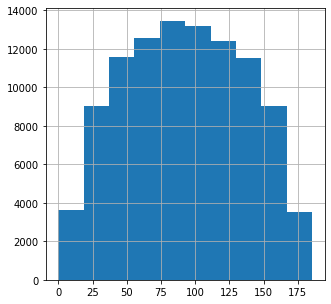

In [17]:
geo_data_0['product'].hist(figsize=(5, 5));

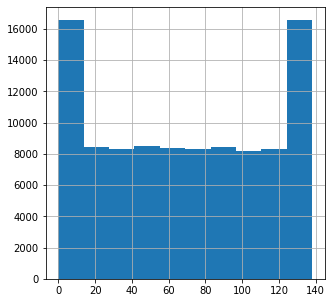

In [18]:
geo_data_1['product'].hist(figsize=(5, 5));

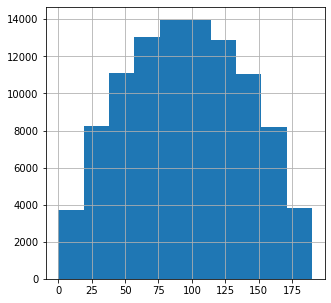

In [19]:
geo_data_2['product'].hist(figsize=(5, 5));

Вывод:
* дубликатов не выявлено
* во всех регионах наибольшая корреляция объёма запасов в скважине наблюдается с признаком f2
* в регионе 1 связь признака f2 с объёмом запасов в скважине приближен к 1 (0,999), что сильно отличается от остальных регионов
* на этом основании проверили распределение в данных в столбце product — объём запасов в скважине. Данные в регионе 1 сильно отличаются, явно присутствуют выбросы. Я не стала избаваляться от них, поскольку нам необходимо сохранять объем данных для дальнейших исследований.

## Обучение и проверка модели

In [10]:
# Разделим признаки и цели по каждому региону
features_geo_0 = geo_data_0.drop(['product'], axis = 1)
target_geo_0 = geo_data_0['product']

features_geo_1 = geo_data_1.drop(['product'], axis = 1)
target_geo_1 = geo_data_1['product']

features_geo_2 = geo_data_2.drop(['product'], axis = 1)
target_geo_2 = geo_data_2['product']

features_train_geo_0, features_valid_geo_0, target_train_geo_0, target_valid_geo_0 = train_test_split(
    features_geo_0, target_geo_0, test_size = 0.25, random_state = 19191)

features_train_geo_1, features_valid_geo_1, target_train_geo_1, target_valid_geo_1 = train_test_split(
    features_geo_1, target_geo_1, test_size = 0.25, random_state = 19191)

features_train_geo_2, features_valid_geo_2, target_train_geo_2, target_valid_geo_2 = train_test_split(
    features_geo_2, target_geo_2, test_size = 0.25, random_state = 19191)

# Проверим размер выборок:
print(target_train_geo_0.shape, target_valid_geo_0.shape)
print(target_train_geo_1.shape, target_valid_geo_1.shape)
print(target_train_geo_2.shape, target_valid_geo_2.shape)

(75000,) (25000,)
(75000,) (25000,)
(75000,) (25000,)


In [11]:
# Создадим массив с тренировочными и валидными наборами
datasets_features_train = [features_train_geo_0, features_train_geo_1, features_train_geo_2]
datasets_targets_train = [target_train_geo_0, target_train_geo_1, target_train_geo_2]

datasets_features_valid = [features_valid_geo_0, features_valid_geo_1, features_valid_geo_2]
datasets_targets_valid = [target_valid_geo_0, target_valid_geo_1, target_valid_geo_2]

# Обучим модели и поместим результаты в datasets_predictions
datasets_predictions = []

for num_geo in range(len(datasets_features_train)):
    model = LinearRegression()
    model.fit(datasets_features_train[num_geo], datasets_targets_train[num_geo])
    predictions = model.predict(datasets_features_valid[num_geo])
    datasets_predictions.append(pd.Series(predictions))
    print('Средний объем запасов скважины региона N' + str(num_geo + 0),  format(predictions.mean(), '.3f'), 'тыс. баррелей')
    print('RMSE', mean_squared_error(datasets_targets_valid[num_geo], predictions) ** 0.5, '\n')

Средний объем запасов скважины региона N0 92.482 тыс. баррелей
RMSE 37.80121847733848 

Средний объем запасов скважины региона N1 68.966 тыс. баррелей
RMSE 0.8869119924293617 

Средний объем запасов скважины региона N2 95.032 тыс. баррелей
RMSE 40.00111945346115 



Вывод:
* Средний объем запасов в нулевом и втором регионах значительно выше, чем в первом
* Однако, благодаря сильной корреляции, получилось достичь наилучший прогноз в модели первого региона. RMSE составила всего лишь 0,89. Предсказания моделей двух других регионов значительно хуже

## Подготовка к расчёту прибыли

In [12]:
#По условиям задачи : 

budget = 10 ** 10   #Бюджет на разработку скважин в регионе 10 млрд. рублей
all_wells = 500 #При разведке исследуют 500 точек
top_wells = 200  # 200 лучших скважин для разработки
cost_of_one_barrel = 450   #Доход с одного барреля сырья 450 рублей
cost_of_one_product = 450000   #Доход с каждой единицы продукта 450 000 рублей

In [13]:
min_product  = budget / top_wells /cost_of_one_product
print('Для безубыточной разработки необходимо чтобы одна скважина добывала не менее:', format(min_product, '.3f'), 'тыс. баррелей')

Для безубыточной разработки необходимо чтобы одна скважина добывала не менее: 111.111 тыс. баррелей


In [14]:
print('Разница между необходимым объемом добычи нефти и средним запасом сырья в скважине в регионе:')
print('N0:', round(geo_data_0['product'].mean() - min_product), 'тыс. баррелей')
print('N1:', round(geo_data_1['product'].mean() - min_product), 'тыс. баррелей')
print('N2:', round(geo_data_2['product'].mean() - min_product), 'тыс. баррелей')

Разница между необходимым объемом добычи нефти и средним запасом сырья в скважине в регионе:
N0: -19 тыс. баррелей
N1: -42 тыс. баррелей
N2: -16 тыс. баррелей


Вывод:
* Для безубыточной разработки скважины необходимо запас не менее: 111.111 тыс. баррелей
* Среднего запаса сырья в скважинах всех трех регионов недостаточно для их безубыточной разработки
* Наибольший убыток, исходя из среднего запаса сырья в скважинах, планируется в регионе 1

## Расчёт прибыли и рисков 

In [15]:
def profit(target, predictions, count):
    predictions_sorted = predictions.sort_values(ascending=False)
    barrels_top_wells = target[predictions_sorted.index][:count]
    return (barrels_top_wells.sum() * cost_of_one_product - budget)

for i in range(3):
    print('Прибыль региона №' +  str(i + 0), profit(datasets_targets_valid[i].reset_index(drop=True), datasets_predictions[i], top_wells))

Прибыль региона №0 3194536662.5349846
Прибыль региона №1 2415086696.681511
Прибыль региона №2 2648065404.619133


95%-й доверительный интервал: (-73753203.25719042 : 997685738.6448472)
Средняя прибыль: 483960504.73
Риск убытка: 4.3 %


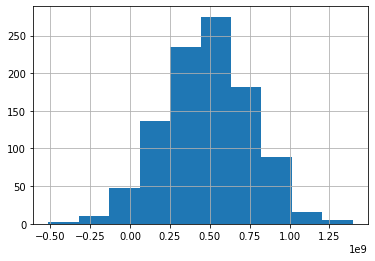

95%-й доверительный интервал: (107340712.18193875 : 957949865.4332703)
Средняя прибыль: 531264608.01
Риск убытка: 0.5 %


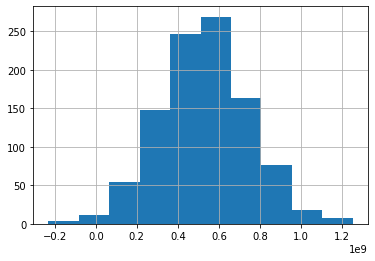

95%-й доверительный интервал: (-192654820.29462948 : 943654489.5383968)
Средняя прибыль: 387003628.90
Риск убытка: 9.2 %


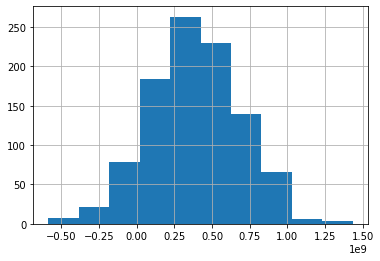

In [16]:
# Bootstrap
values = [[],[],[]]
state = np.random.RandomState(19191)

for i in range(3):
    for j in range(1000):
        target_subsample = datasets_targets_valid[i].reset_index(drop=True).sample(n = all_wells, replace = True, random_state=state)
        probs_subsample = datasets_predictions[i][target_subsample.index]
        
        values[i].append(profit(target_subsample, probs_subsample, top_wells))
        
    values[i] = pd.Series(values[i])
    values[i].hist()
    print('95%-й доверительный интервал: (' + str(values[i].quantile(0.025)) + ' : ' + str(values[i].quantile(0.975)) + ')')
    print('Средняя прибыль:', format(values[i].mean(), '.2f'))
    print('Риск убытка:', (values[i] < 0).mean()* 100, '%')
    plt.show()

## Вывод:
* Данные регионов 0 и2 не будем учитывать, т.к. риск убытка превышает 2.5%.
* В первом регионе риск убытков минимальный - 0,5%. Однако, как было отмечено при подготовке данных, его данные не сопоставимы с другими регионами, т.к. признак f2 коррелирует с трагетом почти на 1. Данный признак (f2) во втором регионе требует дополнительной проверки.

На основании вышеизложенного, необходимо выбрать первый регион, с вероятностью убытков меньше 2.5%. Средняя прибыль составит 531264608.01 руб.